In [1]:
import numpy as np                                                    # Packages for data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle
from scipy.ndimage import gaussian_filter1d
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import ipywidgets as ipw
from IPython.display import HTML, display, Javascript, clear_output
from scipy.sparse import csr_matrix
import scipy.io
from scipy.sparse import coo_matrix
import numpy as np
from decimal import Decimal, getcontext

In [2]:
sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_2_curated.zip')

/tmp/ipykernel_1390416/1646744425.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_2_curated.zip')


In [3]:
sd.N

52

In [4]:
sd.train

[array([2.985000e+01, 1.314500e+02, 2.103000e+02, 2.820500e+02,
        3.433500e+02, 3.943000e+02, 4.541000e+02, 5.446500e+02,
        6.320500e+02, 6.875500e+02, 7.760500e+02, 8.251500e+02,
        8.953500e+02, 9.684000e+02, 1.023800e+03, 1.094500e+03,
        1.150850e+03, 1.213900e+03, 1.272300e+03, 1.332050e+03,
        1.385800e+03, 1.437350e+03, 1.528700e+03, 1.569650e+03,
        1.623900e+03, 1.671500e+03, 1.738400e+03, 1.805550e+03,
        1.875100e+03, 2.039850e+03, 2.108250e+03, 2.178350e+03,
        2.249000e+03, 2.313200e+03, 2.368600e+03, 2.422700e+03,
        2.485950e+03, 2.561600e+03, 2.633450e+03, 2.692050e+03,
        2.768400e+03, 2.821600e+03, 2.902450e+03, 2.962050e+03,
        3.036000e+03, 3.087800e+03, 3.142050e+03, 3.198350e+03,
        3.256250e+03, 3.347100e+03, 3.409500e+03, 3.477700e+03,
        3.553600e+03, 3.598550e+03, 3.643250e+03, 3.695050e+03,
        3.767150e+03, 3.829050e+03, 3.889150e+03, 3.943100e+03,
        4.019950e+03, 4.109050e+03, 4.17

In [5]:
s_train = sd.train

In [6]:
neural_unit_index = []
spike_times = []

In [7]:
for index, array in enumerate(s_train):
    neural_unit_index.extend([index] * len(array))
    spike_times.extend(array)
    
result_array = np.column_stack((neural_unit_index, spike_times))

In [8]:
result_array[:,1] /= 1000

In [9]:
result_array[:, 0] += 1

In [10]:
result_array.shape

(2669, 2)

In [11]:
len(np.unique(result_array[:, 0]))

52

In [12]:
import scipy.io as sio
import os

In [13]:
current_directory = os.getcwd()

# Provide the file name for the .mat file
file_name = "Human_Data.mat"
file_full_path = os.path.join(current_directory, file_name)

# Create a dictionary to store the numpy array with a specific variable name
data_to_save = {"spks": result_array}

# Save the dictionary to a .mat file
sio.savemat(file_full_path, data_to_save)

In [24]:
def createFCM(spksExc, spksInh=None):    
    
    # time constant of exponential profile (used for coupling)
    tau = 3e-3

    # 1e-4 binless window step in seconds
    step = 1e-4
    
    # store ids of neurons that really fired -- corresponding to entries in
    # adjacency relation
    
    if spksInh is None:
        old_ids = np.unique(spksExc[:, 0])
        spks = np.column_stack((spksExc, np.ones(len(spksExc))))
    else:
        old_ids = np.unique(np.concatenate((spksExc[:, 0], spksInh[:, 0])))
        spks = np.row_stack((np.column_stack((spksExc, np.ones(len(spksExc)))), 
                             np.column_stack((spksInh, -np.ones(len(spksInh))))))
        
    Eneuron_end = np.max(spksExc[:, 0])
    num_neurons = len(old_ids)
    
    row_indices = old_ids - 1  # Since Python uses 0-based indexing, we subtract 1 from old_ids
    col_indices = np.zeros_like(row_indices)
    values = np.arange(1, num_neurons + 1)

    new_ids = coo_matrix((values, (row_indices, col_indices)), shape=(num_neurons, 1))
    
    # frequency of spiking for individual neurons
    spike_freq = np.zeros(num_neurons)
    
    # duration of spike trains
    t_min = 0
    t_max = np.max(spksExc[:,1])
    T = t_max - t_min
    sig_length = np.ceil(T/step).astype(int)
    
    # Convert the new_ids sparse matrix to a dense NumPy array
    new_ids_array = new_ids.toarray().flatten()

    print(Eneuron_end)

    # Get spiking frequencies
    spike_freq = np.zeros(num_neurons)

    for i in range(1, num_neurons + 1):
        if i <= Eneuron_end:
            neuron_spikes = spksExc[spksExc[:, 0] == old_ids[i - 1], 1]
            spike_freq[i - 1] = np.sum(neuron_spikes) / T
        else:
            if spksInh is None:
                print("spksInh is None. Make sure it is properly defined.")
                return None
                
            neuron_spikes = spksInh[spksInh[:, 0] == old_ids[i - 1], 1]
            spike_freq[i - 1] = np.sum(neuron_spikes) / T
            
    # create signals for each neuron        
    signals = np.zeros((num_neurons, sig_length))
    for i in range(1, num_neurons + 1):
        k = old_ids[i - 1]
        IorE = np.unique(spks[spks[:, 0] == k, 2])
        # how neuron i will influence other neurons
        signals[i - 1, :] = create_signal(spks[spks[:, 0] == k, 1], step, sig_length, tau, IorE)
    
    FC_MAT = np.zeros((num_neurons, num_neurons))
    spike_vecs = np.zeros((num_neurons, sig_length))

    # Previous code up to combining with discrete spiking events...

    # Combine with discrete spiking events
    for i in range(1, num_neurons + 1):
        k = old_ids[i - 1]
        spike_times = spks[spks[:, 0] == k, 1]
        spike_times_vec = coo_matrix((np.ones_like(spike_times), 
                                      (np.ceil(spike_times / step).astype(int) - 1, 
                                       np.zeros_like(spike_times))), 
                                     shape=(sig_length, 1)).toarray().flatten()
        spike_vecs[i - 1, :] = spike_times_vec
        # Influence on neuron i from all other neurons.
        FC_MAT[:, i - 1] = signals.dot(spike_times_vec)

    # Thresholding
    FC_MAT[FC_MAT < 0] = 0
    FC_MAT = FC_MAT - np.diag(np.diag(FC_MAT))

    # Frequency normalization
    freq_normalization = spike_freq / np.maximum(spike_freq, 1)  # Divide element-wise with maximum value of 1
    freq_normalization[freq_normalization > 1] = 1

    FC_MAT = FC_MAT * freq_normalization

    return FC_MAT

In [25]:
def create_signal(start_times, dt, sig_length, tau, mode):
    # time vector
    t_vec = np.arange(dt, (sig_length + 1) * dt, dt)

    q = np.zeros_like(t_vec)

    if mode == 1:
        for k in range(len(start_times)):
            qq = np.exp(-(t_vec - start_times[k]) / tau)
            qq[qq > 1] = 0
            if k < len(start_times) - 1:
                qq[t_vec >= start_times[k + 1]] = 0
            q = q + qq
    else:
        for k in range(len(start_times)):
            qq = np.exp(-(t_vec - start_times[k]) / tau)
            qq[qq > 1] = 0
            qq = 1 - qq
            qq[qq > 0.99] = 0  # corresponds to ~4.5 tau
            if k < len(start_times) - 1:
                qq[t_vec >= start_times[k + 1]] = 0
            q = q + qq

    # due to rounding of spiking times, the exponential may sometimes not start at 1
    if mode == 1:
        idx = np.ceil(start_times / dt).astype(int) - 1
        idx = np.clip(idx, 0, len(q) - 1)  # Clip indices to be within valid range
        q[idx] = 1

    # shift to zero mean and make magnitude normalized
    q = q - np.mean(q)
    q = q / (np.max(q) * len(start_times))

    return q

In [26]:
FC_MAT = createFCM(result_array)

52.0


/tmp/ipykernel_1389491/3072996499.py:9: RuntimeWarning: overflow encountered in exp
  qq = np.exp(-(t_vec - start_times[k]) / tau)


In [27]:
FC_MAT

array([[0.00000000e+00, 4.44829368e-04, 1.12624210e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.49555305e-03],
       [7.29293890e-03, 6.93282835e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.58730170e-03, 3.41225597e-03],
       [0.00000000e+00, 2.85290507e-02, 0.00000000e+00, ...,
        2.37508618e-05, 0.00000000e+00, 0.00000000e+00],
       [1.97239768e-03, 0.00000000e+00, 0.00000000e+00, ...,
        8.23125699e-04, 0.00000000e+00, 0.00000000e+00]])

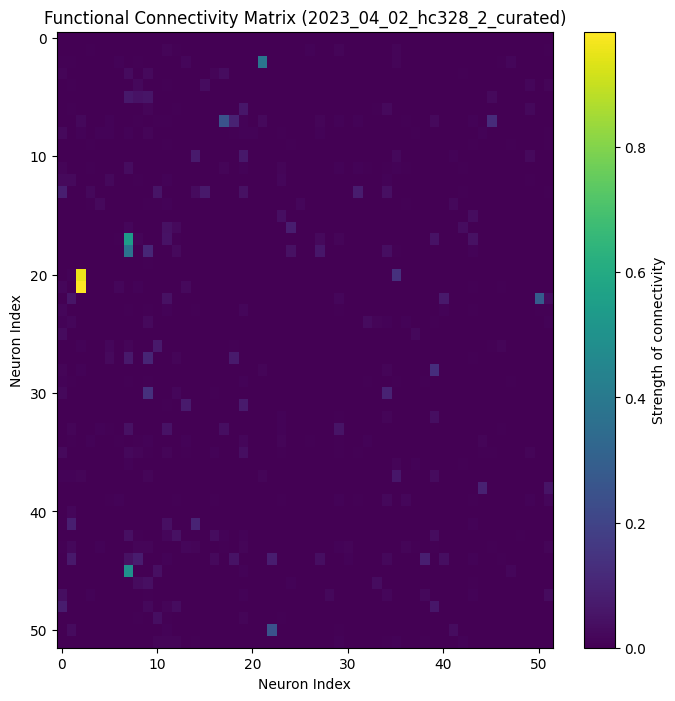

In [30]:
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
heatmap = plt.imshow(FC_MAT, cmap='viridis', aspect='auto')
colorbar = plt.colorbar(heatmap)  # Add a colorbar for better interpretation
colorbar.set_label('Strength of connectivity')  # Add the label to the colorbar
plt.title('Functional Connectivity Matrix (2023_04_02_hc328_2_curated)')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()